In [1]:
# Install TA-lib and, ccxt, optuna
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
%pip install Ta-Lib
%pip install ccxt
%pip install optuna

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the repository
repo_path = '/content/drive/MyDrive/tradingBot'
%cd {repo_path}

# Pull the latest changes
!git pull origin main

UsageError: Line magic function `%wget` not found.


In [1]:
from model_utils import CryptoDataset, check_for_missing_data, normalize_data, create_targets, create_features, feature_cut, profitable_percent, distribution, pipeline
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import HeNormal
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from optuna.pruners import SuccessiveHalvingPruner
import numpy as np

2024-12-30 22:36:47.580129: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735623407.607237    5434 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735623407.616435    5434 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 22:36:47.642209: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please

In [2]:
print(tf.test.is_built_with_cuda())  # Should return True
print(tf.config.list_physical_devices('GPU'))  # Should list your GPU


True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:

# Objective function for optimization
def objective(trial):

    # MODEL CREATION
    params_grid = {
        # LSTM Units
        "lstm_units_1": trial.suggest_categorical("lstm_units_1", [64, 128, 256]),
        "lstm_units_2": trial.suggest_categorical("lstm_units_2", [32, 64, 128]),

        # Dropout rate for regularization
        "dropout": trial.suggest_categorical("dropout", [0.1, 0.2, 0.3, 0.5]),

        # Learning rate for the optimizer (log scale for better range)
        "learning_rate": trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True),

        # Batch size (common choices)
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),

        # Dense layer units (for fully connected layers after LSTM)
        "dense_units": trial.suggest_categorical("dense_units", [16, 32, 64, 128]),

        # Sequence length (historical data considered for prediction)
        "sequence_length": trial.suggest_categorical("sequence_length", [10, 20, 50, 100]),

        # Gradient clipping for preventing exploding gradients
        "gradient_clipping": trial.suggest_categorical("gradient_clipping", [0.5, 1.0, 2.0]),

        # Optimizer choice (Adam or RMSprop)
        "optimizer": trial.suggest_categorical("optimizer", ['adam', 'rmsprop']),

        # Activation function for layers
        "activation": trial.suggest_categorical("activation", ['relu', 'tanh'])
    }

    # DATA CREATION AND PROCESSING
    timeframe_filenames = {
    "1m": "data/DOGEUSDT_1m_v0.csv",
    "3m": "data/DOGEUSDT_3m_v0.csv",
    "5m": "data/DOGEUSDT_5m_v0.csv",
    "15m": "data/DOGEUSDT_15m_v0.csv",
    "30m": "data/DOGEUSDT_30m_v0.csv"
}
    # Timeframe to trade on
    timeframe = trial.suggest_categorical('timeframe', ["1m", "3m", "5m", "15m", "30m"])
    timeframe_file = timeframe_filenames[timeframe]
    
    # Defaulting to 50000 samples
    sample_size = trial.suggest_int('sample_size', 50000, 50000)
    
    # The number of indicators to be used in the model
    num_indicators = trial.suggest_int('num_indicators', 5, 46)
    
    # The scaler of the data
    scaler_type = trial.suggest_categorical('scaler', ['MinMaxScaler', 'StandardScaler', 'RobustScaler'])
    
    # How big the look behind window is
    window_size = trial.suggest_int('window_size', 10, 135)  # Example range for window size
    
    # How far in the future to trade
    look_ahead_size = trial.suggest_int('look_ahead_size', 5, 50)

    # PROFIT FUNCTION VALUES
    # Create the simulate trading values
    prediction_tolerance_max = trial.suggest_float('predTolMax', 0.8, 1)
    prediction_tolerance_min = trial.suggest_float('predTolMin', 0.8, 1)
    # When to trade
    trade_threshold = trial.suggest_float('trade_threshold', 0.0005, .02)

    # print everthing
    print(f'HyperParams: Timeframe: {timeframe_file}, Num Indicators: {num_indicators}, Scaler: {scaler_type}, Window Size: {window_size}, Look ahead Size: {look_ahead_size}, Dropout: {params_grid}, Pred_tol_Max: {prediction_tolerance_max}, Pred_tol_Min: {prediction_tolerance_min}, Trade Threshold: {trade_threshold}')
    
    # run
    current_model = pipeline()
    current_model.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, params_grid, prediction_tolerance_max, prediction_tolerance_min, trade_threshold, sample_size)
    
    # Calculate profit per trade per normalized time
    timeframe_int = int(''.join(filter(str.isdigit, timeframe)))
    total_profit, total_trades = current_model.full_stack(trial=trial, filename=timeframe_file)

    # Check if the trial is pruned after training
    if trial.should_prune():
        print("Trial pruned after training.")
        raise optuna.exceptions.TrialPruned()

    ppt = total_profit / total_trades if total_trades != 0 else 0
    pptpnt = ppt / (timeframe_int * look_ahead_size)
    
    
    return pptpnt

In [4]:
# JUST ONE TRIAL

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

# Create and run the Optuna study
study = optuna.create_study(direction='maximize', pruner=pruner)

study.optimize(objective, n_trials=1)  # Run 1 trial

# Get the best parameters
print("Best parameters:", study.best_params)

[I 2024-12-30 22:34:48,078] A new study created in memory with name: no-name-6fd2d9d5-7034-464d-b151-fd36adb66ddc


HyperParams: Timeframe: data/DOGEUSDT_30m_v0.csv, Num Indicators: 31, Scaler: MinMaxScaler, Window Size: 103, Look ahead Size: 27, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.004013212009747622, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.953994605494854, Pred_tol_Min: 0.9739196927883512, Trade Threshold: 0.0013899993839901717
Dataset loaded from data/DOGEUSDT_30m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!


[W 2024-12-30 22:34:53,813] Trial 0 failed with parameters: {'lstm_units_1': 256, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.004013212009747622, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 50, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'relu', 'timeframe': '30m', 'sample_size': 50000, 'num_indicators': 31, 'scaler': 'MinMaxScaler', 'window_size': 103, 'look_ahead_size': 27, 'predTolMax': 0.953994605494854, 'predTolMin': 0.9739196927883512, 'trade_threshold': 0.0013899993839901717} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_4665/4243951976.py", line 78, in objective
    total_profit, total_trades = current_model.full_stack(trial=trial, filename=timeframe_file)
  File "/home/jonas/Projects/trading_bot/model_utils.py

KeyboardInterrupt: 

In [10]:

storage_path = "sqlite:///study.db"

#optuna.delete_study(study_name="the_study", storage=storage_path)

pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=10)

study = optuna.load_study(storage=storage_path, study_name="the_study")

# Create and run the Optuna study
#study = optuna.create_study(storage=storage_path, study_name="the_study", direction='maximize', pruner=pruner)

study.optimize(objective, n_trials=300)  # Run 300 trials

# Get the best parameters
print("Best parameters:", study.best_params)


HyperParams: Timeframe: data/DOGEUSDT_3m_v0.csv, Num Indicators: 46, Scaler: MinMaxScaler, Window Size: 111, Look ahead Size: 23, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.3, 'learning_rate': 0.003903995225180346, 'batch_size': 16, 'dense_units': 64, 'sequence_length': 10, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.9098781935788941, Pred_tol_Min: 0.8180990486192504, Trade Threshold: 0.014145630134589965
Dataset loaded from data/DOGEUSDT_3m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
   1/2178 ━━━━━━━━━━━━━━━━━━━━ 3:14:17 5s/step - loss: 9628.6953 - mae: 66.6851NaN detected in batch 2, pruning trial.
   3/2178 ━━━━━━━━━━━━━━━━━━━━ 1:43 48ms/step - loss: nan - mae: nan           

/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/pruners/_percentile.py:20: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(values)
[I 2024-12-30 23:56:28,526] Trial 28 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_3m_v0.csv, Num Indicators: 14, Scaler: RobustScaler, Window Size: 60, Look ahead Size: 18, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 0.0002012200799791833, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'tanh'}, Pred_tol_Max: 0.9786412015370886, Pred_tol_Min: 0.975423994736468, Trade Threshold: 0.01725364393370185
Dataset loaded from data/DOGEUSDT_3m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
269/273 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0678 - mae: 0.1823

[I 2024-12-30 23:56:53,716] Trial 29 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_1m_v0.csv, Num Indicators: 29, Scaler: StandardScaler, Window Size: 32, Look ahead Size: 9, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.5, 'learning_rate': 0.02297820196815837, 'batch_size': 64, 'dense_units': 16, 'sequence_length': 50, 'gradient_clipping': 1.0, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.8554369615420865, Pred_tol_Min: 0.9316262790958371, Trade Threshold: 0.017718600749493944
Dataset loaded from data/DOGEUSDT_1m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
546/546 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 104154172409675533720223744.0000 - mae: 679366426624.0000

[I 2024-12-30 23:57:28,709] Trial 30 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_15m_v0.csv, Num Indicators: 42, Scaler: RobustScaler, Window Size: 134, Look ahead Size: 29, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 32, 'dropout': 0.2, 'learning_rate': 1.0039455601573712e-05, 'batch_size': 32, 'dense_units': 16, 'sequence_length': 20, 'gradient_clipping': 0.5, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.9389610973601342, Pred_tol_Min: 0.9019891142741152, Trade Threshold: 0.008016966850208572
Dataset loaded from data/DOGEUSDT_15m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
 111/1089 ━━━━━━━━━━━━━━━━━━━━ 37s 38ms/step - loss: 228008067072.0000 - mae: 23605.6562NaN detected in batch 111, pruning trial.
 112/1089 ━━━━━━━━━━━━━━━━━━━━ 37s 39ms/step - loss: nan - mae: nan                     

/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/pruners/_percentile.py:20: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(values)
[I 2024-12-30 23:58:06,104] Trial 31 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_1m_v0.csv, Num Indicators: 37, Scaler: StandardScaler, Window Size: 93, Look ahead Size: 50, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.007407383804474213, 'batch_size': 32, 'dense_units': 128, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.9698948404631067, Pred_tol_Min: 0.854569042851221, Trade Threshold: 0.005994143907764225
Dataset loaded from data/DOGEUSDT_1m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
   1/1089 ━━━━━━━━━━━━━━━━━━━━ 1:31:27 5s/step - loss: 448680.5312 - mae: 152.6196NaN detected in batch 2, pruning trial.
   3/1089 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: nan - mae: nan               

/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/pruners/_percentile.py:20: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(values)
[I 2024-12-30 23:58:36,242] Trial 32 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_1m_v0.csv, Num Indicators: 38, Scaler: StandardScaler, Window Size: 72, Look ahead Size: 50, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.016988951909947946, 'batch_size': 32, 'dense_units': 128, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.9850307618547731, Pred_tol_Min: 0.8647996783890031, Trade Threshold: 0.006492002868793952
Dataset loaded from data/DOGEUSDT_1m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
   1/1090 ━━━━━━━━━━━━━━━━━━━━ 1:34:53 5s/step - loss: 5755.8340 - mae: 26.9258NaN detected in batch 2, pruning trial.


/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/pruners/_percentile.py:20: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(values)
[I 2024-12-30 23:59:06,801] Trial 33 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_1m_v0.csv, Num Indicators: 35, Scaler: StandardScaler, Window Size: 97, Look ahead Size: 43, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.0031889936326777316, 'batch_size': 32, 'dense_units': 128, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu'}, Pred_tol_Max: 0.9656377802167836, Pred_tol_Min: 0.8352878370007913, Trade Threshold: 0.003759661353851011
Dataset loaded from data/DOGEUSDT_1m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 12292111312146149670912.0000 - mae: 6517218816.0000

[I 2024-12-30 23:59:57,274] Trial 34 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_5m_v0.csv, Num Indicators: 42, Scaler: StandardScaler, Window Size: 88, Look ahead Size: 47, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 0.006862912048407247, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'relu'}, Pred_tol_Max: 0.9574783560543779, Pred_tol_Min: 0.9402434864659452, Trade Threshold: 0.007791443779652423
Dataset loaded from data/DOGEUSDT_5m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 31s 23ms/step - loss: 2737151901102036221952.0000 - mae: 2732705024.0000 - val_loss: 0.1505 - val_mae: 0.2993
Epoch 2/50
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 61294.1094 - mae: 1.2452 - val_loss: 0.0604 - val_mae: 0.1737
Epoch 3/50
1089/1089 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 230.4356 - mae: 0.1990 - val_loss: 0.0568 - val_mae: 0.

[I 2024-12-31 00:03:13,045] Trial 35 finished with value: -3.9029964682413265e-05 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 0.006862912048407247, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'relu', 'timeframe': '5m', 'sample_size': 50000, 'num_indicators': 42, 'scaler': 'StandardScaler', 'window_size': 88, 'look_ahead_size': 47, 'predTolMax': 0.9574783560543779, 'predTolMin': 0.9402434864659452, 'trade_threshold': 0.007791443779652423}. Best is trial 1 with value: 0.0.


HyperParams: Timeframe: data/DOGEUSDT_1m_v0.csv, Num Indicators: 43, Scaler: StandardScaler, Window Size: 106, Look ahead Size: 46, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.0018429452692868737, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'relu'}, Pred_tol_Max: 0.9779720494492984, Pred_tol_Min: 0.8912911885327435, Trade Threshold: 0.011158020065847965
Dataset loaded from data/DOGEUSDT_1m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - loss: 10773659647383403757568.0000 - mae: 16213611520.0000 - val_loss: 1569768192.0000 - val_mae: 11627.1455
Epoch 2/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 565374272.0000 - mae: 2854.6853 - val_loss: 0.1234 - val_mae: 0.3027
Epoch 3/50
273/273 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0707 - mae: 0.2167 - val_loss: 0.0

[I 2024-12-31 00:06:29,023] Trial 36 finished with value: 0.0 and parameters: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.0018429452692868737, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 100, 'gradient_clipping': 0.5, 'optimizer': 'adam', 'activation': 'relu', 'timeframe': '1m', 'sample_size': 50000, 'num_indicators': 43, 'scaler': 'StandardScaler', 'window_size': 106, 'look_ahead_size': 46, 'predTolMax': 0.9779720494492984, 'predTolMin': 0.8912911885327435, 'trade_threshold': 0.011158020065847965}. Best is trial 1 with value: 0.0.


Predictions:[[ 0.00616142 -0.00766317]
 [ 0.00616209 -0.00766297]
 [ 0.00615132 -0.00766582]
 [ 0.00616209 -0.00766297]
 [ 0.00616209 -0.00766297]
 [ 0.00616209 -0.00766297]
 [ 0.00616209 -0.00766297]
 [ 0.00616209 -0.00766297]
 [ 0.00616209 -0.00766297]
 [ 0.00616209 -0.00766297]]
Y-Tests:[[ 0.00334872 -0.00132742]
 [ 0.01599486 -0.        ]
 [ 0.00490363 -0.00133453]
 [ 0.01326865 -0.00240956]
 [ 0.014145   -0.02041014]
 [ 0.00646233 -0.00096633]
 [ 0.00292067 -0.0176134 ]
 [ 0.00192916 -0.00471221]
 [ 0.         -0.00987706]
 [ 0.00199538 -0.02204415]]
TP:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
SL:[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tot Profit: 0, Wins: 0, Loses: 0, No-Hits: 0 No-trade: 7464
HyperParams: Timeframe: data/DOGEUSDT_5m_v0.csv, Num Indicators: 24, Scaler: RobustScaler, Window Size: 22, Look ahead Size: 40, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.003909986260104385, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 10, 'gradient_clippi

[I 2024-12-31 00:08:01,793] Trial 37 finished with value: -6.229363498277962e-05 and parameters: {'lstm_units_1': 64, 'lstm_units_2': 64, 'dropout': 0.3, 'learning_rate': 0.003909986260104385, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 10, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'tanh', 'timeframe': '5m', 'sample_size': 50000, 'num_indicators': 24, 'scaler': 'RobustScaler', 'window_size': 22, 'look_ahead_size': 40, 'predTolMax': 0.992859763715278, 'predTolMin': 0.8763855995762428, 'trade_threshold': 0.01889525914051851}. Best is trial 1 with value: 0.0.


HyperParams: Timeframe: data/DOGEUSDT_15m_v0.csv, Num Indicators: 39, Scaler: MinMaxScaler, Window Size: 40, Look ahead Size: 35, Dropout: {'lstm_units_1': 128, 'lstm_units_2': 32, 'dropout': 0.1, 'learning_rate': 0.0526716453366811, 'batch_size': 128, 'dense_units': 64, 'sequence_length': 50, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'tanh'}, Pred_tol_Max: 0.9095526187820567, Pred_tol_Min: 0.8444560209767026, Trade Threshold: 0.0041956667144447835
Dataset loaded from data/DOGEUSDT_15m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
272/273 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5430 - mae: 0.8500

[I 2024-12-31 00:08:27,363] Trial 38 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_3m_v0.csv, Num Indicators: 35, Scaler: MinMaxScaler, Window Size: 85, Look ahead Size: 17, Dropout: {'lstm_units_1': 64, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.012867807666063649, 'batch_size': 16, 'dense_units': 128, 'sequence_length': 100, 'gradient_clipping': 1.0, 'optimizer': 'adam', 'activation': 'relu'}, Pred_tol_Max: 0.9759215653334362, Pred_tol_Min: 0.8257848855048914, Trade Threshold: 0.01030178940733465
Dataset loaded from data/DOGEUSDT_3m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
2180/2180 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 377915820627336091892521254256640.0000 - mae: 226176719126528.0000

[I 2024-12-31 00:09:37,367] Trial 39 pruned. Trial was pruned at epoch 0.


HyperParams: Timeframe: data/DOGEUSDT_30m_v0.csv, Num Indicators: 15, Scaler: StandardScaler, Window Size: 73, Look ahead Size: 41, Dropout: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.1, 'learning_rate': 0.0006780270343811945, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 10, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'tanh'}, Pred_tol_Max: 0.9401422840463586, Pred_tol_Min: 0.8620205620551947, Trade Threshold: 0.012622062753425787
Dataset loaded from data/DOGEUSDT_30m_v0.csv.
Loaded into pipeline.data
Data Preprocessed!
Data Split, Shuffled, and y normalized!
Epoch 1/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - loss: 0.0266 - mae: 0.1079 - val_loss: 0.1263 - val_mae: 0.2795
Epoch 2/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0058 - mae: 0.0556 - val_loss: 0.1078 - val_mae: 0.2595
Epoch 3/50
1090/1090 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0041 - mae: 0.0472 - val_loss: 0.1188 - val_mae: 0.2717
Epoch 4/50
1090/1090 ━━━

[I 2024-12-31 00:12:05,409] Trial 40 finished with value: -8.463161975669209e-06 and parameters: {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.1, 'learning_rate': 0.0006780270343811945, 'batch_size': 32, 'dense_units': 32, 'sequence_length': 10, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'tanh', 'timeframe': '30m', 'sample_size': 50000, 'num_indicators': 15, 'scaler': 'StandardScaler', 'window_size': 73, 'look_ahead_size': 41, 'predTolMax': 0.9401422840463586, 'predTolMin': 0.8620205620551947, 'trade_threshold': 0.012622062753425787}. Best is trial 1 with value: 0.0.


Predictions:[[ 0.04182854  0.00433514]
 [ 0.19116391  0.00489206]
 [ 0.09580094 -0.13113654]
 [ 0.03137533 -0.00777421]
 [ 0.26139838 -0.07375391]
 [ 0.13478284 -0.02997361]
 [ 0.10077574 -0.07672876]
 [ 0.00663285 -0.01190231]
 [ 0.13359429 -0.00176428]
 [ 0.02818097 -0.01694327]]
Y-Tests:[[ 0.02220349 -0.03775529]
 [ 0.04642253 -0.14862233]
 [ 0.04640279 -0.00821509]
 [ 0.02558357 -0.00177404]
 [ 0.04692992 -0.02370737]
 [ 0.02875441 -0.03083654]
 [ 0.35252629 -0.01157819]
 [-0.00384464 -0.02819401]
 [ 0.00365271 -0.08618171]
 [ 0.04545057 -0.02692072]]
TP:[np.float32(0.039324775), np.float32(0.17972128), np.float32(0.090066515), np.float32(0.029497277), np.float32(0.24575166), np.float32(0.12671505), np.float32(0.094743535), 0, np.float32(0.12559764), np.float32(0.026494117)]
SL:[np.float32(0.0037369768), np.float32(0.004217056), np.float32(-0.11304239), np.float32(-0.0067015267), np.float32(-0.063577384), np.float32(-0.02583787), np.float32(-0.06614177), 0, np.float32(-0.0015208491

[W 2024-12-31 00:12:16,034] Trial 41 failed with parameters: {'lstm_units_1': 128, 'lstm_units_2': 64, 'dropout': 0.1, 'learning_rate': 4.4878742149438624e-05, 'batch_size': 128, 'dense_units': 128, 'sequence_length': 20, 'gradient_clipping': 2.0, 'optimizer': 'rmsprop', 'activation': 'relu', 'timeframe': '1m', 'sample_size': 50000, 'num_indicators': 29, 'scaler': 'StandardScaler', 'window_size': 117, 'look_ahead_size': 10, 'predTolMax': 0.8925968959088955, 'predTolMin': 0.8764727709216756, 'trade_threshold': 0.009165995944401407} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_5434/3042852226.py", line 78, in objective
    total_profit, total_trades = current_model.full_stack(trial=trial, filename=timeframe_file)
  File "/home/jonas/Projects/trading_bot/model_util

KeyboardInterrupt: 

In [ ]:
# Objective function for optimization
def custom_model(params):

    # model params
    model_keys = [
    'lstm_units_1', 'lstm_units_2', 'dropout', 'learning_rate', 'batch_size',
    'dense_units', 'sequence_length', 'gradient_clipping', 'optimizer', 'activation'
]
    # Create the new dictionary using dictionary comprehension
    params_grid = {key: params[key] for key in model_keys}

    # Get a file name for the timeframe
    timeframe_filenames = {
    "1m": "data/DOGEUSDT_1m_v0.csv",
    "3m": "data/DOGEUSDT_3m_v0.csv",
    "5m": "data/DOGEUSDT_5m_v0.csv",
    "15m": "data/DOGEUSDT_15m_v0.csv",
    "30m": "data/DOGEUSDT_30m_v0.csv"
}
    timeframe_file = timeframe_filenames[params['timeframe']]
    
    # run
    current_model = pipeline()
    current_model.pass_hyperparams(params['timeframe'], params['num_indicators'], params['scaler'], params['window_size'], params['look_ahead_size'], params_grid, params['predTolMax'], params['predTolMin'], params['trade_threshold'], params['sample_size'])
    
    current_model.full_stack(filename=timeframe_file)
   
    return current_model.model
    

In [ ]:
params = {'lstm_units_1': 256, 'lstm_units_2': 128, 'dropout': 0.2, 'learning_rate': 0.000833475067744133, 'batch_size': 16, 'dense_units': 16, 'sequence_length': 100, 'gradient_clipping': 2.0, 'optimizer': 'adam', 'activation': 'tanh', 'timeframe': '15m', 'sample_size': 50000, 'num_indicators': 31, 'scaler': 'RobustScaler', 'window_size': 16, 'look_ahead_size': 40, 'predTolMax': 0.9303641151019011, 'predTolMin': 0.8728821078255877, 'trade_threshold': 0.016253333877016652}

model = custom_model(params)

In [ ]:
candles = raw


def get_trade(candles, params, model):
    
    # model params
    model_keys = [
    'lstm_units_1', 'lstm_units_2', 'dropout', 'learning_rate', 'batch_size',
    'dense_units', 'sequence_length', 'gradient_clipping', 'optimizer', 'activation'
]
    # Create the new dictionary using dictionary comprehension
    params_grid = {key: params[key] for key in model_keys}
    
    predictor_model = pipeline()
    predictor_model.pass_hyperparams(params['timeframe'], params['num_indicators'], params['scaler'], params['window_size'], params['look_ahead_size'], params_grid, params['predTolMax'], params['predTolMin'], params['trade_threshold'], 1)

    predictor_model.model = model
    predictor_model.preprocess()
    


In [6]:
i = 200

timeframe= '30m'
scaler_type = 'RobustScaler'

look_ahead_size = 40
dropout_rate = .2
num_indicators = 20
prediction_tolerance_max = .95 
prediction_tolerance_min = .95
trade_threshold = .02

while (i > 20):
    modelv1 = pipeline()
    window_size = i
    i -= 5
    print(f"Window Size: {window_size}")
    modelv1.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)

    modelv1.load_file(filename='data/DOGEUSD_30m_vo.csv')
    modelv1.preprocess()
    modelv1.target_creation()
    modelv1.split_data()
    modelv1.train()

Window Size: 200


TypeError: pipeline.pass_hyperparams() missing 1 required positional argument: 'sample_size'

In [18]:
timeframe= '30m'
num_indicators = 20
scaler_type = 'RobustScaler'
window_size = 151
look_ahead_size = 46
dropout_rate = .49

prediction_tolerance_max = .95 
prediction_tolerance_min = .95
trade_threshold = .02

modelv1 = pipeline()
modelv1.pass_hyperparams(timeframe, num_indicators, scaler_type, window_size, look_ahead_size, dropout_rate, prediction_tolerance_max, prediction_tolerance_min, trade_threshold)

modelv1.load_file(filename='data/DOGEUSD_30m_vo.csv')
modelv1.preprocess()
modelv1.target_creation()
modelv1.split_data()

Dataset loaded from data/DOGEUSD_30m_vo.csv.
Loaded into pipeline.data


/home/jonas/Projects/trading_bot/model_utils.py:432: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['close'] = feature_df['close']  # Add the target column back if needed


Data Preprocessed!
Data Split!


In [19]:
np.isnan(modelv1.X_train).any()


np.False_

In [20]:


modelv1.train()

Epoch 1/50


2024-12-25 23:01:14.086057: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 449315600 exceeds 10% of free system memory.


1163/1163 ━━━━━━━━━━━━━━━━━━━━ 174s 147ms/step - loss: 46026926833270784.0000 - mae: 8662324.0000 - val_loss: 292779263524864.0000 - val_mae: 274475.2500
Epoch 2/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 162s 139ms/step - loss: 6826168418304.0000 - mae: 26561.7988 - val_loss: 12004608000.0000 - val_mae: 4675.8516
Epoch 3/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 198s 170ms/step - loss: 52035971081243197440.0000 - mae: 106486480.0000 - val_loss: 6289352196169400320.0000 - val_mae: 118290536.0000
Epoch 4/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 181s 155ms/step - loss: 103412006487402217472.0000 - mae: 111667816.0000 - val_loss: 7336033779712.0000 - val_mae: 289142.3438
Epoch 5/50
1163/1163 ━━━━━━━━━━━━━━━━━━━━ 149s 128ms/step - loss: 11993684362919936.0000 - mae: 4984188.0000 - val_loss: 70355142049792.0000 - val_mae: 795298.5000
Epoch 6/50
 479/1163 ━━━━━━━━━━━━━━━━━━━━ 1:28 129ms/step - loss: 686727555448832.0000 - mae: 1821143.7500

KeyboardInterrupt: 

In [4]:
modelv1.load_Model('Scaled')

I0000 00:00:1735018336.286763   11177 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5503 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:02:00.0, compute capability: 6.1


In [5]:
total_profit, X_test, y_test, y_train, predictions = modelv1.return_profit()

2024-12-23 22:32:19.036227: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 103540000 exceeds 10% of free system memory.
I0000 00:00:1735018339.421893   11456 service.cc:148] XLA service 0x7ed27c006120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1735018339.421911   11456 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce GTX 1060, Compute Capability 6.1
2024-12-23 22:32:19.448703: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1735018339.560770   11456 cuda_dnn.cc:529] Loaded cuDNN version 90300


 25/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

I0000 00:00:1735018340.007764   11456 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


324/324 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Predictions:[[ 0.017639   -0.01618808]
 [ 0.01709265 -0.01639809]
 [ 0.03048979 -0.0284367 ]
 [ 0.02442027 -0.02138515]
 [ 0.047548   -0.03698634]
 [ 0.01369887 -0.0134461 ]
 [ 0.01835247 -0.01714688]
 [ 0.02041945 -0.02195122]
 [ 0.01888651 -0.01614244]
 [ 0.02414487 -0.02079504]]
Y-Tests:[[ 0.00485437 -0.00970874]
 [-0.00283286 -0.01983003]
 [ 0.01490826 -0.03555046]
 [ 0.02336449  0.00155763]
 [-0.01451613 -0.14354839]
 [ 0.00412882 -0.0015139 ]
 [ 0.06666667  0.00296296]
 [-0.00286944 -0.06025825]
 [ 0.0049505  -0.03041018]
 [ 0.00142349 -0.02918149]]
TP:[0, 0, np.float32(0.028965302), np.float32(0.023199258), np.float32(0.045170598), 0, 0, np.float32(0.019398475), 0, np.float32(0.022937626)]
SL:[0, 0, np.float32(-0.027014868), np.float32(-0.02031589), np.float32(-0.035137028), 0, 0, np.float32(-0.02085366), 0, np.float32(-0.019755285)]
Tot Profit: -57.683440510754934, Wins: 3430, Loses: 1640, No-trade: 5284


In [10]:
len(predictions)

10354

2024-12-23 22:32:30,170 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,176 - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-12-23 22:32:30,181 - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/cmb10.ttf', name='cmb10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
2024-12-23 22:32:30,183 - DEBUG - findfont: score(FontEntry(fname='/home/jonas/Projects/trading_bot/.venv/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymBol.ttf', name='STIXSizeOneSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
2024-12-23 22:32:30,184 - DEBUG - findfont: score(FontEntry(fname='/

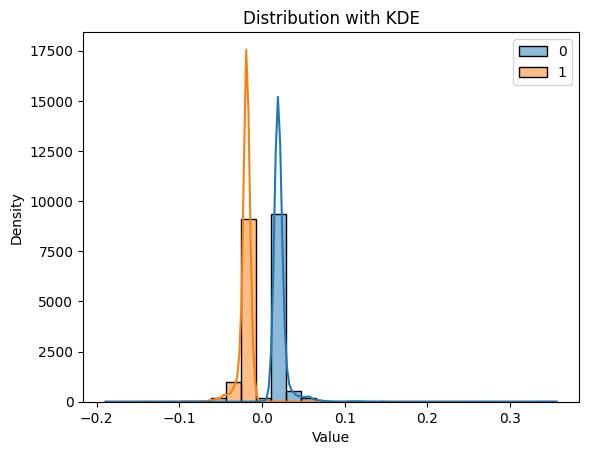

In [6]:
distribution(predictions)

In [33]:
# Make predictions
predictions = model.predict(X_test)

# Extract actual mix and max percentage changes
actual_max = [pair[0] for pair in y_test]
actual_min = [pair[1] for pair in y_test]

# Extract predicted max and min percentage changes
predicted_max = predictions[:, 0]
predicted_min = predictions[:, 1]

max_difference = actual_max - predicted_max


317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 30ms/step


In [ ]:
import matplotlib.pyplot as plt # This sets the appropriate backend for Jupyter notebooks


import numpy as np

cut = 25
max_difference_cut = [max_difference[i]*100 for i in range(len(max_difference)) if i % cut == 0]

# max cuts
predicted_max_cut = [predicted_max[i]*100 for i in range(len(predicted_max)) if i % cut == 0]
actual_max_cut = [actual_max[i]*100 for i in range(len(actual_max)) if i % cut == 0]

# min cuts
predicted_min_cut = [predicted_min[i]*100 for i in range(len(predicted_min)) if i % cut == 0]
actual_min_cut = [actual_min[i]*100 for i in range(len(actual_min)) if i % cut == 0]

#df = pd.DataFrame(X_test)
#y_test = df.iloc[:, 2].to_numpy()

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Size of the figure
#plt.plot(max_difference_25, label='Variation', color='green')  # Plot actual values
plt.plot(actual_max_cut, label='Actual', color='red')  # Plot actual values
plt.plot(predicted_max_cut, label='Predicted', color='blue')  # Plot predicted values

# Add labels and title
plt.xlabel('Index')  # You can also use time or other labels
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')

# Show legend
plt.legend()

# Show the plot
plt.show()


NameError: name 'max_difference' is not defined